In [2]:
import datetime
import numpy as np
import pandas_datareader as pdr
import esig
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import base
from utils import tosig
from utils.leadlag import leadlag
from rough_bergomi import rough_bergomi

from importlib import reload
import cvae_keras
reload(cvae_keras)
import cvae_tfp
reload(cvae_tfp)

import matplotlib.pyplot as plt

## Data processing

In [3]:
# # S&P 500
# data = pdr.get_data_yahoo("^GSPC", datetime.date(2000, 1, 1), datetime.date(2019, 1, 1))["Close"]
# windows = []
# for _, window in data.resample('M'):
#     values = window.values
#     path = leadlag(values)
#     windows.append(path)

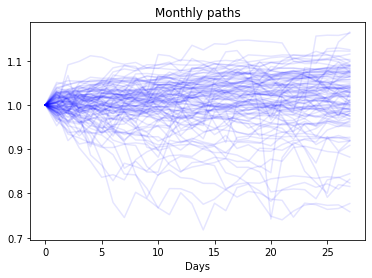

In [5]:
# Actually for rough_bergomi model, conditional VAE does no help because the cond are independent

# rough_bergomi
params = {
            "M": 100,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }

def _load_rough_bergomi(params, test_use = False):
    grid_points_dict = {"M": 28, "W": 5, "Y": 252}
    grid_points = grid_points_dict['M']
    params["T"] = grid_points / grid_points_dict["Y"]
    paths = rough_bergomi(grid_points, **params)
    if test_use:
        windows = paths
    else:   
        windows = [leadlag(path) for path in paths]
    return windows

windows = _load_rough_bergomi(params)

for path in windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.1)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

In [12]:
len(windows), windows[0].shape

(100, (55, 2))

## Log-signature computing

In [6]:
order = 4
def _logsig(path):
    return esig.tosig.stream2logsig(path, order)
def _sig(path):
    return esig.tosig.stream2sig(path, order)
orig_logsig = np.array([_logsig(path) for path in tqdm(windows, desc="Computing log-signatures")])
orig_sig = np.array([_sig(path) for path in tqdm(windows, desc="Computing signatures")])
scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig = scaler.fit_transform(orig_logsig)
logsigs = logsig[1:]   # 1 week forecasting 1 week 
conditions = logsig[:-1] 

## TFP

In [7]:
model = cvae_tfp.CVAE_circle(logsigs.shape[-1], conditions.shape[-1], encoder =cvae_tfp.EncoderNormal,\
                            latent_dim=8, n_hidden = 50, weight=0.003)
def zero_error(y_true, y_pred):
    return tf.constant(0., dtype='float32')
model.compile(optimizer='adam', loss=zero_error)
model.evaluate(x = [logsigs, conditions], y = np.zeros(shape= (logsigs.shape[0],1)))
model.fit(x = [logsigs, conditions], y = np.zeros(shape= (logsigs.shape[0],1)), epochs=10000,\
                 batch_size=logsigs.shape[0], verbose = True)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
99/99 [==============================] - 0s 3ms/sample - loss: 1.4074
Train on 99 samples
Epoch 1/10000
99/99 [==============================] - 1s 9ms/sample - loss: 1.3522
Epoch 2/10000
99/99 [==============================] - 0s 83us/sample - loss: 1.3649
Epoch 3/10000
99/99 [==============================] - 0s 21us/sample - loss: 1.2292
Epoch 4/10000
99/99 [==============================] - 0s 20us/sample - loss: 1.1826
Epoch 5/10000
99/99 [==============================] - 0s 20us/sample - loss: 1.2039
Epoch 6/10000
99/99 [==============================] - 0s 20us/sample - loss: 1.1602
Epoch 7/10000
99/99 [==============================] - 0s 20us/sample - loss: 1.0615
Epoch 8/10000
99/99 [==============================] - 0s 20us/sample - loss: 1.0384
Epoch 9/10000
99/99 [==============================] - 0s 30us/sample - loss: 1.0016
Epoch 10/10000
99/99 [==============================] - 0s 

Epoch 89/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1683
Epoch 90/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1742
Epoch 91/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1733
Epoch 92/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1721
Epoch 93/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1622
Epoch 94/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.1711
Epoch 95/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.1860
Epoch 96/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.1752
Epoch 97/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1592
Epoch 98/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.1787
Epoch 99/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1601
Epoch 100/10000
99/99 [==============================]

Epoch 184/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.1259
Epoch 185/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.1412
Epoch 186/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1253
Epoch 187/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.1150
Epoch 188/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1081
Epoch 189/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1290
Epoch 190/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.1296
Epoch 191/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1228
Epoch 192/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.1281
Epoch 193/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1226
Epoch 194/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.1274
Epoch 195/10000
99/99 [====================

Epoch 279/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0756
Epoch 280/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0798
Epoch 281/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0802
Epoch 282/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0736
Epoch 283/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0742
Epoch 284/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0721
Epoch 285/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0671
Epoch 286/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0644
Epoch 287/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0689
Epoch 288/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0643
Epoch 289/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0641
Epoch 290/10000
99/99 [====================

Epoch 374/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0485
Epoch 375/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0471
Epoch 376/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0448
Epoch 377/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0419
Epoch 378/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0459
Epoch 379/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0465
Epoch 380/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0443
Epoch 381/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0482
Epoch 382/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0443
Epoch 383/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0397
Epoch 384/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0483
Epoch 385/10000
99/99 [====================

Epoch 469/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0419
Epoch 470/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0382
Epoch 471/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0433
Epoch 472/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0426
Epoch 473/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0434
Epoch 474/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0383
Epoch 475/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0370
Epoch 476/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0378
Epoch 477/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0397
Epoch 478/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0418
Epoch 479/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0398
Epoch 480/10000
99/99 [====================

Epoch 564/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0383
Epoch 565/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0373
Epoch 566/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0348
Epoch 567/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0382
Epoch 568/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0359
Epoch 569/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0355
Epoch 570/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0360
Epoch 571/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0383
Epoch 572/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0364
Epoch 573/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0355
Epoch 574/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0340
Epoch 575/10000
99/99 [====================

99/99 [==============================] - 0s 20us/sample - loss: 0.0316
Epoch 659/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0347
Epoch 660/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0326
Epoch 661/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0355
Epoch 662/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0348
Epoch 663/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0362
Epoch 664/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0346
Epoch 665/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0353
Epoch 666/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0396
Epoch 667/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0355
Epoch 668/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0328
Epoch 669/10000
99/99 [==============================] - 0s

Epoch 753/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0316
Epoch 754/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0308
Epoch 755/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0339
Epoch 756/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0325
Epoch 757/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0307
Epoch 758/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0329
Epoch 759/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0293
Epoch 760/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0317
Epoch 761/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0315
Epoch 762/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0321
Epoch 763/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0325
Epoch 764/10000
99/99 [====================

99/99 [==============================] - 0s 20us/sample - loss: 0.0287
Epoch 848/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0281
Epoch 849/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0292
Epoch 850/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0329
Epoch 851/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0332
Epoch 852/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0298
Epoch 853/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0299
Epoch 854/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0284
Epoch 855/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0296
Epoch 856/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0295
Epoch 857/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0300
Epoch 858/10000
99/99 [==============================] - 0s

Epoch 942/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0304
Epoch 943/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0273
Epoch 944/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0290
Epoch 945/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0295
Epoch 946/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0283
Epoch 947/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0298
Epoch 948/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0292
Epoch 949/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0297
Epoch 950/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0273
Epoch 951/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0314
Epoch 952/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0271
Epoch 953/10000
99/99 [====================

Epoch 1036/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0266
Epoch 1037/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0266
Epoch 1038/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0258
Epoch 1039/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0287
Epoch 1040/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0255
Epoch 1041/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0285
Epoch 1042/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0248
Epoch 1043/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0265
Epoch 1044/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0269
Epoch 1045/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0248
Epoch 1046/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0281
Epoch 1047/10000
99/99 [========

Epoch 1130/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0242
Epoch 1131/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0270
Epoch 1132/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0250
Epoch 1133/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0252
Epoch 1134/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0255
Epoch 1135/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0253
Epoch 1136/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0241
Epoch 1137/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0251
Epoch 1138/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0271
Epoch 1139/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0256
Epoch 1140/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0243
Epoch 1141/10000
99/99 [========

Epoch 1224/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0266
Epoch 1225/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0230
Epoch 1226/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0260
Epoch 1227/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0255
Epoch 1228/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0239
Epoch 1229/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0245
Epoch 1230/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0244
Epoch 1231/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0261
Epoch 1232/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0240
Epoch 1233/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0242
Epoch 1234/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0249
Epoch 1235/10000
99/99 [========

Epoch 1318/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0229
Epoch 1319/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0265
Epoch 1320/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0249
Epoch 1321/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0234
Epoch 1322/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0251
Epoch 1323/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0238
Epoch 1324/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0222
Epoch 1325/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0235
Epoch 1326/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0233
Epoch 1327/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0250
Epoch 1328/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0252
Epoch 1329/10000
99/99 [========

99/99 [==============================] - 0s 20us/sample - loss: 0.0238
Epoch 1412/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0219
Epoch 1413/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0218
Epoch 1414/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0222
Epoch 1415/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0232
Epoch 1416/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0247
Epoch 1417/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0224
Epoch 1418/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0229
Epoch 1419/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0224
Epoch 1420/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0225
Epoch 1421/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0217
Epoch 1422/10000
99/99 [=========================

Epoch 1505/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0238
Epoch 1506/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0231
Epoch 1507/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0224
Epoch 1508/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0211
Epoch 1509/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0215
Epoch 1510/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0231
Epoch 1511/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0229
Epoch 1512/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0234
Epoch 1513/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0224
Epoch 1514/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0219
Epoch 1515/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0214
Epoch 1516/10000
99/99 [========

Epoch 1599/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0209
Epoch 1600/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0207
Epoch 1601/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0220
Epoch 1602/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0221
Epoch 1603/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0213
Epoch 1604/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0229
Epoch 1605/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0203
Epoch 1606/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0227
Epoch 1607/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0211
Epoch 1608/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0231
Epoch 1609/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0216
Epoch 1610/10000
99/99 [========

Epoch 1693/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0209
Epoch 1694/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0219
Epoch 1695/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0222
Epoch 1696/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0206
Epoch 1697/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0229
Epoch 1698/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0210
Epoch 1699/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0220
Epoch 1700/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0214
Epoch 1701/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0211
Epoch 1702/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0212
Epoch 1703/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0219
Epoch 1704/10000
99/99 [========

Epoch 1787/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0215
Epoch 1788/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0209
Epoch 1789/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0216
Epoch 1790/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0216
Epoch 1791/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0211
Epoch 1792/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0217
Epoch 1793/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0220
Epoch 1794/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0212
Epoch 1795/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0234
Epoch 1796/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0211
Epoch 1797/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0217
Epoch 1798/10000
99/99 [========

Epoch 1881/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0197
Epoch 1882/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0216
Epoch 1883/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0213
Epoch 1884/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0215
Epoch 1885/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0213
Epoch 1886/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0199
Epoch 1887/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0212
Epoch 1888/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0203
Epoch 1889/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0218
Epoch 1890/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0206
Epoch 1891/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0210
Epoch 1892/10000
99/99 [========

Epoch 1975/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0208
Epoch 1976/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0201
Epoch 1977/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0228
Epoch 1978/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0195
Epoch 1979/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0206
Epoch 1980/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0198
Epoch 1981/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0211
Epoch 1982/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0208
Epoch 1983/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0202
Epoch 1984/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0202
Epoch 1985/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0206
Epoch 1986/10000
99/99 [========

Epoch 2069/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0202
Epoch 2070/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0206
Epoch 2071/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0211
Epoch 2072/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0205
Epoch 2073/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0197
Epoch 2074/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0200
Epoch 2075/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0210
Epoch 2076/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0200
Epoch 2077/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0205
Epoch 2078/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0199
Epoch 2079/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0205
Epoch 2080/10000
99/99 [========

Epoch 2163/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0204
Epoch 2164/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0197
Epoch 2165/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0207
Epoch 2166/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0190
Epoch 2167/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0204
Epoch 2168/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0190
Epoch 2169/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0199
Epoch 2170/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0195
Epoch 2171/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0203
Epoch 2172/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0208
Epoch 2173/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0190
Epoch 2174/10000
99/99 [========

Epoch 2257/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0197
Epoch 2258/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0193
Epoch 2259/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0197
Epoch 2260/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0198
Epoch 2261/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0202
Epoch 2262/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0202
Epoch 2263/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0190
Epoch 2264/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0183
Epoch 2265/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0207
Epoch 2266/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0193
Epoch 2267/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0200
Epoch 2268/10000
99/99 [========

Epoch 2351/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0201
Epoch 2352/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0191
Epoch 2353/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0204
Epoch 2354/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0199
Epoch 2355/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0188
Epoch 2356/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0195
Epoch 2357/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0196
Epoch 2358/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0195
Epoch 2359/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0202
Epoch 2360/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0193
Epoch 2361/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0193
Epoch 2362/10000
99/99 [========

Epoch 2445/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0201
Epoch 2446/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0190
Epoch 2447/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0190
Epoch 2448/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0188
Epoch 2449/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0206
Epoch 2450/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0185
Epoch 2451/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0190
Epoch 2452/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0186
Epoch 2453/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0194
Epoch 2454/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0182
Epoch 2455/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0191
Epoch 2456/10000
99/99 [========

Epoch 2539/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0185
Epoch 2540/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0183
Epoch 2541/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0182
Epoch 2542/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0194
Epoch 2543/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0210
Epoch 2544/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0195
Epoch 2545/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0183
Epoch 2546/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0187
Epoch 2547/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0190
Epoch 2548/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0190
Epoch 2549/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0193
Epoch 2550/10000
99/99 [========

Epoch 2633/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0193
Epoch 2634/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0184
Epoch 2635/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0196
Epoch 2636/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0183
Epoch 2637/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0183
Epoch 2638/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0187
Epoch 2639/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0193
Epoch 2640/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0179
Epoch 2641/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0189
Epoch 2642/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0195
Epoch 2643/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0186
Epoch 2644/10000
99/99 [========

Epoch 2727/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0185
Epoch 2728/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0181
Epoch 2729/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0182
Epoch 2730/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0185
Epoch 2731/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0181
Epoch 2732/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0185
Epoch 2733/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0176
Epoch 2734/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0184
Epoch 2735/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0184
Epoch 2736/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0187
Epoch 2737/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0184
Epoch 2738/10000
99/99 [========

99/99 [==============================] - 0s 20us/sample - loss: 0.0179
Epoch 2821/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0186
Epoch 2822/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0181
Epoch 2823/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0182
Epoch 2824/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0180
Epoch 2825/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0183
Epoch 2826/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0178
Epoch 2827/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0182
Epoch 2828/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0184
Epoch 2829/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0179
Epoch 2830/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0191
Epoch 2831/10000
99/99 [=========================

Epoch 2914/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0179
Epoch 2915/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0181
Epoch 2916/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0181
Epoch 2917/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0184
Epoch 2918/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0175
Epoch 2919/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0183
Epoch 2920/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0179
Epoch 2921/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0176
Epoch 2922/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0179
Epoch 2923/10000
99/99 [==============================] - 0s 29us/sample - loss: 0.0177
Epoch 2924/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0187
Epoch 2925/10000
99/99 [========

Epoch 3008/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0172
Epoch 3009/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 3010/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0182
Epoch 3011/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0184
Epoch 3012/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0176
Epoch 3013/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 3014/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0172
Epoch 3015/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0188
Epoch 3016/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0179
Epoch 3017/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0183
Epoch 3018/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0176
Epoch 3019/10000
99/99 [========

Epoch 3102/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0170
Epoch 3103/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 3104/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0174
Epoch 3105/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 3106/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0172
Epoch 3107/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0180
Epoch 3108/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 3109/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 3110/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 3111/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0177
Epoch 3112/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 3113/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 3196/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 3197/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0181
Epoch 3198/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 3199/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0176
Epoch 3200/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0186
Epoch 3201/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0178
Epoch 3202/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0173
Epoch 3203/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 3204/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0172
Epoch 3205/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0176
Epoch 3206/10000
99/99 [=========================

Epoch 3289/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 3290/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0165
Epoch 3291/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0176
Epoch 3292/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0163
Epoch 3293/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 3294/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0166
Epoch 3295/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 3296/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0169
Epoch 3297/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 3298/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0170
Epoch 3299/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0177
Epoch 3300/10000
99/99 [========

Epoch 3383/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 3384/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 3385/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0172
Epoch 3386/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0164
Epoch 3387/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 3388/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0168
Epoch 3389/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0166
Epoch 3390/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 3391/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0168
Epoch 3392/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0176
Epoch 3393/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0168
Epoch 3394/10000
99/99 [========

Epoch 3477/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0164
Epoch 3478/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0169
Epoch 3479/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 3480/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0173
Epoch 3481/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0167
Epoch 3482/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0174
Epoch 3483/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0169
Epoch 3484/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0176
Epoch 3485/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0162
Epoch 3486/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0163
Epoch 3487/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0167
Epoch 3488/10000
99/99 [========

Epoch 3571/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0169
Epoch 3572/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0171
Epoch 3573/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 3574/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0168
Epoch 3575/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0164
Epoch 3576/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0166
Epoch 3577/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0166
Epoch 3578/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 3579/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0177
Epoch 3580/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0157
Epoch 3581/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 3582/10000
99/99 [========

Epoch 3665/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0160
Epoch 3666/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0164
Epoch 3667/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0161
Epoch 3668/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0167
Epoch 3669/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 3670/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0163
Epoch 3671/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 3672/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0160
Epoch 3673/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 3674/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0156
Epoch 3675/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0157
Epoch 3676/10000
99/99 [========

Epoch 3759/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 3760/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0158
Epoch 3761/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0164
Epoch 3762/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 3763/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 3764/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0154
Epoch 3765/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 3766/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 3767/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 3768/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 3769/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 3770/10000
99/99 [========

Epoch 3853/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0163
Epoch 3854/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0157
Epoch 3855/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 3856/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0166
Epoch 3857/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0164
Epoch 3858/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 3859/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0165
Epoch 3860/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 3861/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0162
Epoch 3862/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 3863/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0160
Epoch 3864/10000
99/99 [========

Epoch 3947/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0165
Epoch 3948/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0157
Epoch 3949/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0162
Epoch 3950/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 3951/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0156
Epoch 3952/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0164
Epoch 3953/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0153
Epoch 3954/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0155
Epoch 3955/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0166
Epoch 3956/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0168
Epoch 3957/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0153
Epoch 3958/10000
99/99 [========

Epoch 4041/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 4042/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0153
Epoch 4043/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0156
Epoch 4044/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0162
Epoch 4045/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0153
Epoch 4046/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0155
Epoch 4047/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 4048/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0157
Epoch 4049/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 4050/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0160
Epoch 4051/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 4052/10000
99/99 [========

Epoch 4135/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0156
Epoch 4136/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0158
Epoch 4137/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0150
Epoch 4138/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0154
Epoch 4139/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 4140/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0162
Epoch 4141/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0153
Epoch 4142/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0158
Epoch 4143/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0161
Epoch 4144/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0156
Epoch 4145/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0158
Epoch 4146/10000
99/99 [========

Epoch 4229/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0156
Epoch 4230/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0149
Epoch 4231/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0155
Epoch 4232/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0154
Epoch 4233/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0158
Epoch 4234/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 4235/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0155
Epoch 4236/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0147
Epoch 4237/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0148
Epoch 4238/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0149
Epoch 4239/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0155
Epoch 4240/10000
99/99 [========

Epoch 4323/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0152
Epoch 4324/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0154
Epoch 4325/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0150
Epoch 4326/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0150
Epoch 4327/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0143
Epoch 4328/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0157
Epoch 4329/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0155
Epoch 4330/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 4331/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0155
Epoch 4332/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0149
Epoch 4333/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0156
Epoch 4334/10000
99/99 [========

Epoch 4417/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 4418/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0150
Epoch 4419/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0155
Epoch 4420/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0153
Epoch 4421/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0147
Epoch 4422/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0151
Epoch 4423/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0150
Epoch 4424/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0151
Epoch 4425/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0150
Epoch 4426/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0148
Epoch 4427/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0151
Epoch 4428/10000
99/99 [========

Epoch 4511/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0153
Epoch 4512/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 4513/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0148
Epoch 4514/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 4515/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 4516/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0149
Epoch 4517/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 4518/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0154
Epoch 4519/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0154
Epoch 4520/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0154
Epoch 4521/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0152
Epoch 4522/10000
99/99 [========

Epoch 4605/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 4606/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0149
Epoch 4607/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 4608/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0147
Epoch 4609/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0151
Epoch 4610/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0149
Epoch 4611/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0148
Epoch 4612/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0149
Epoch 4613/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0141
Epoch 4614/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0146
Epoch 4615/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0152
Epoch 4616/10000
99/99 [========

Epoch 4699/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0145
Epoch 4700/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0149
Epoch 4701/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0150
Epoch 4702/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0144
Epoch 4703/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 4704/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0149
Epoch 4705/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0150
Epoch 4706/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0146
Epoch 4707/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0152
Epoch 4708/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 4709/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0147
Epoch 4710/10000
99/99 [========

Epoch 4793/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0141
Epoch 4794/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0144
Epoch 4795/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 4796/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0145
Epoch 4797/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 4798/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 4799/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0148
Epoch 4800/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0146
Epoch 4801/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0153
Epoch 4802/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0157
Epoch 4803/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0150
Epoch 4804/10000
99/99 [========

Epoch 4887/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 4888/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0150
Epoch 4889/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0143
Epoch 4890/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0138
Epoch 4891/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 4892/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 4893/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 4894/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 4895/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0139
Epoch 4896/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 4897/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0149
Epoch 4898/10000
99/99 [========

Epoch 4981/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0145
Epoch 4982/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0145
Epoch 4983/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0141
Epoch 4984/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 4985/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0136
Epoch 4986/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0145
Epoch 4987/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0152
Epoch 4988/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0143
Epoch 4989/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0146
Epoch 4990/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0145
Epoch 4991/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0139
Epoch 4992/10000
99/99 [========

Epoch 5075/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 5076/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 5077/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 5078/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0148
Epoch 5079/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 5080/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0137
Epoch 5081/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 5082/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0146
Epoch 5083/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0143
Epoch 5084/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0146
Epoch 5085/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 5086/10000
99/99 [========

Epoch 5169/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 5170/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0139
Epoch 5171/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0143
Epoch 5172/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 5173/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0150
Epoch 5174/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0138
Epoch 5175/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0142
Epoch 5176/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 5177/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 5178/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0139
Epoch 5179/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 5180/10000
99/99 [========

Epoch 5263/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0143
Epoch 5264/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5265/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 5266/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 5267/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 5268/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 5269/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0142
Epoch 5270/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0141
Epoch 5271/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0147
Epoch 5272/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 5273/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0140
Epoch 5274/10000
99/99 [========

Epoch 5357/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 5358/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 5359/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0139
Epoch 5360/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0135
Epoch 5361/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5362/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0139
Epoch 5363/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5364/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 5365/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5366/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 5367/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 5368/10000
99/99 [========

Epoch 5451/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5452/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 5453/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 5454/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0138
Epoch 5455/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 5456/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5457/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0141
Epoch 5458/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0141
Epoch 5459/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0139
Epoch 5460/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0142
Epoch 5461/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0139
Epoch 5462/10000
99/99 [========

Epoch 5545/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0145
Epoch 5546/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 5547/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0135
Epoch 5548/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 5549/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0141
Epoch 5550/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0140
Epoch 5551/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5552/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0135
Epoch 5553/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0157
Epoch 5554/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 5555/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 5556/10000
99/99 [========

Epoch 5639/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 5640/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0139
Epoch 5641/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 5642/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 5643/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0142
Epoch 5644/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 5645/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 5646/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0156
Epoch 5647/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 5648/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0136
Epoch 5649/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0140
Epoch 5650/10000
99/99 [========

Epoch 5733/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0129
Epoch 5734/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0139
Epoch 5735/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0134
Epoch 5736/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0143
Epoch 5737/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 5738/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 5739/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0143
Epoch 5740/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 5741/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 5742/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0141
Epoch 5743/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 5744/10000
99/99 [========

Epoch 5827/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0139
Epoch 5828/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0140
Epoch 5829/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0139
Epoch 5830/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0135
Epoch 5831/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 5832/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0146
Epoch 5833/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0142
Epoch 5834/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0143
Epoch 5835/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 5836/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 5837/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5838/10000
99/99 [========

99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 5921/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0131
Epoch 5922/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5923/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5924/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 5925/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5926/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0141
Epoch 5927/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 5928/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 5929/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 5930/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 5931/10000
99/99 [=========================

Epoch 6014/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 6015/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 6016/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 6017/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 6018/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 6019/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0139
Epoch 6020/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 6021/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 6022/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0134
Epoch 6023/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 6024/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 6025/10000
99/99 [========

Epoch 6108/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 6109/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0135
Epoch 6110/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0136
Epoch 6111/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0136
Epoch 6112/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 6113/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 6114/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 6115/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0135
Epoch 6116/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 6117/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 6118/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 6119/10000
99/99 [========

Epoch 6202/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 6203/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 6204/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 6205/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0133
Epoch 6206/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 6207/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 6208/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 6209/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 6210/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0143
Epoch 6211/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 6212/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 6213/10000
99/99 [========

Epoch 6296/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 6297/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0142
Epoch 6298/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0131
Epoch 6299/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0136
Epoch 6300/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 6301/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0136
Epoch 6302/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 6303/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 6304/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0141
Epoch 6305/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0135
Epoch 6306/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0143
Epoch 6307/10000
99/99 [========

99/99 [==============================] - 0s 20us/sample - loss: 0.0142
Epoch 6390/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 6391/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 6392/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0136
Epoch 6393/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0144
Epoch 6394/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 6395/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0132
Epoch 6396/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0136
Epoch 6397/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0128
Epoch 6398/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 6399/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 6400/10000
99/99 [=========================

Epoch 6483/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 6484/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0141
Epoch 6485/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 6486/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0134
Epoch 6487/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 6488/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 6489/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0134
Epoch 6490/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0135
Epoch 6491/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 6492/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0135
Epoch 6493/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 6494/10000
99/99 [========

Epoch 6577/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 6578/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0132
Epoch 6579/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0134
Epoch 6580/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0137
Epoch 6581/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0140
Epoch 6582/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 6583/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 6584/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0127
Epoch 6585/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0132
Epoch 6586/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 6587/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0129
Epoch 6588/10000
99/99 [========

Epoch 6671/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0129
Epoch 6672/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0135
Epoch 6673/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0139
Epoch 6674/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 6675/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0133
Epoch 6676/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0130
Epoch 6677/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0128
Epoch 6678/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0137
Epoch 6679/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0135
Epoch 6680/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0127
Epoch 6681/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0131
Epoch 6682/10000
99/99 [========

Epoch 6765/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0132
Epoch 6766/10000
99/99 [==============================] - 0s 11us/sample - loss: 0.0134
Epoch 6767/10000
99/99 [==============================] - 0s 33us/sample - loss: 0.0129
Epoch 6768/10000
99/99 [==============================] - 0s 32us/sample - loss: 0.0132
Epoch 6769/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 6770/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 6771/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 6772/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 6773/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 6774/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 6775/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 6776/10000
99/99 [========

Epoch 6859/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 6860/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 6861/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0137
Epoch 6862/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0137
Epoch 6863/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 6864/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 6865/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0125
Epoch 6866/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0134
Epoch 6867/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 6868/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 6869/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0131
Epoch 6870/10000
99/99 [========

Epoch 6953/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0129
Epoch 6954/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0136
Epoch 6955/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0146
Epoch 6956/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 6957/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0128
Epoch 6958/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 6959/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 6960/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 6961/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 6962/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0127
Epoch 6963/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 6964/10000
99/99 [========

Epoch 7047/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 7048/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 7049/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 7050/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 7051/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 7052/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0127
Epoch 7053/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 7054/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 7055/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 7056/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0123
Epoch 7057/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0134
Epoch 7058/10000
99/99 [========

Epoch 7141/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 7142/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 7143/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0136
Epoch 7144/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0135
Epoch 7145/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 7146/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 7147/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 7148/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 7149/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 7150/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 7151/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0131
Epoch 7152/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0127
Epoch 7235/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0137
Epoch 7236/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0138
Epoch 7237/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 7238/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 7239/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0131
Epoch 7240/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 7241/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 7242/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 7243/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 7244/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 7245/10000
99/99 [=========================

Epoch 7328/10000
99/99 [==============================] - 0s 13us/sample - loss: 0.0131
Epoch 7329/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0132
Epoch 7330/10000
99/99 [==============================] - 0s 26us/sample - loss: 0.0136
Epoch 7331/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0124
Epoch 7332/10000
99/99 [==============================] - 0s 45us/sample - loss: 0.0131
Epoch 7333/10000
99/99 [==============================] - 0s 22us/sample - loss: 0.0127
Epoch 7334/10000
99/99 [==============================] - 0s 22us/sample - loss: 0.0128
Epoch 7335/10000
99/99 [==============================] - 0s 25us/sample - loss: 0.0128
Epoch 7336/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 7337/10000
99/99 [==============================] - 0s 29us/sample - loss: 0.0135
Epoch 7338/10000
99/99 [==============================] - 0s 24us/sample - loss: 0.0127
Epoch 7339/10000
99/99 [========

99/99 [==============================] - 0s 40us/sample - loss: 0.0130
Epoch 7422/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 7423/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 7424/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 7425/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 7426/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0130
Epoch 7427/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 7428/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0128
Epoch 7429/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0129
Epoch 7430/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0132
Epoch 7431/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0132
Epoch 7432/10000
99/99 [=========================

Epoch 7515/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 7516/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 7517/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 7518/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 7519/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0135
Epoch 7520/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 7521/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0133
Epoch 7522/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0134
Epoch 7523/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 7524/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 7525/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 7526/10000
99/99 [========

Epoch 7609/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0125
Epoch 7610/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 7611/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0129
Epoch 7612/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 7613/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 7614/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 7615/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 7616/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 7617/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 7618/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 7619/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0128
Epoch 7620/10000
99/99 [========

Epoch 7703/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0125
Epoch 7704/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 7705/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 7706/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 7707/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 7708/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 7709/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 7710/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 7711/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 7712/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 7713/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0134
Epoch 7714/10000
99/99 [========

Epoch 7797/10000
99/99 [==============================] - 0s 29us/sample - loss: 0.0127
Epoch 7798/10000
99/99 [==============================] - 0s 23us/sample - loss: 0.0128
Epoch 7799/10000
99/99 [==============================] - 0s 28us/sample - loss: 0.0131
Epoch 7800/10000
99/99 [==============================] - 0s 24us/sample - loss: 0.0131
Epoch 7801/10000
99/99 [==============================] - 0s 26us/sample - loss: 0.0124
Epoch 7802/10000
99/99 [==============================] - 0s 16us/sample - loss: 0.0125
Epoch 7803/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0130
Epoch 7804/10000
99/99 [==============================] - 0s 28us/sample - loss: 0.0129
Epoch 7805/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0123
Epoch 7806/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0125
Epoch 7807/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0125
Epoch 7808/10000
99/99 [==========

Epoch 7891/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 7892/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 7893/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0132
Epoch 7894/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0132
Epoch 7895/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0130
Epoch 7896/10000
99/99 [==============================] - 0s 22us/sample - loss: 0.0126
Epoch 7897/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0127
Epoch 7898/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0126
Epoch 7899/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0124
Epoch 7900/10000
99/99 [==============================] - 0s 26us/sample - loss: 0.0129
Epoch 7901/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0123
Epoch 7902/10000
99/99 [==========

Epoch 7985/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0127
Epoch 7986/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0132
Epoch 7987/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0130
Epoch 7988/10000
99/99 [==============================] - 0s 26us/sample - loss: 0.0131
Epoch 7989/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0128
Epoch 7990/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0136
Epoch 7991/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0129
Epoch 7992/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0129
Epoch 7993/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0127
Epoch 7994/10000
99/99 [==============================] - 0s 23us/sample - loss: 0.0128
Epoch 7995/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0127
Epoch 7996/10000
99/99 [==========

Epoch 8079/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0131
Epoch 8080/10000
99/99 [==============================] - 0s 19us/sample - loss: 0.0127
Epoch 8081/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0124
Epoch 8082/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 8083/10000
99/99 [==============================] - 0s 19us/sample - loss: 0.0123
Epoch 8084/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0133
Epoch 8085/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0127
Epoch 8086/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0129
Epoch 8087/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0128
Epoch 8088/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0120
Epoch 8089/10000
99/99 [==============================] - 0s 29us/sample - loss: 0.0124
Epoch 8090/10000
99/99 [============

Epoch 8173/10000
99/99 [==============================] - 0s 6us/sample - loss: 0.0131
Epoch 8174/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0124
Epoch 8175/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0134
Epoch 8176/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0129
Epoch 8177/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0130
Epoch 8178/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0125
Epoch 8179/10000
99/99 [==============================] - 0s 37us/sample - loss: 0.0138
Epoch 8180/10000
99/99 [==============================] - 0s 15us/sample - loss: 0.0128
Epoch 8181/10000
99/99 [==============================] - 0s 22us/sample - loss: 0.0125
Epoch 8182/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0129
Epoch 8183/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0129
Epoch 8184/10000
99/99 [===========

Epoch 8267/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0129
Epoch 8268/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0128
Epoch 8269/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0130
Epoch 8270/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0126
Epoch 8271/10000
99/99 [==============================] - 0s 23us/sample - loss: 0.0127
Epoch 8272/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0128
Epoch 8273/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 8274/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 8275/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 8276/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 8277/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 8278/10000
99/99 [========

Epoch 8361/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0125
Epoch 8362/10000
99/99 [==============================] - 0s 19us/sample - loss: 0.0120
Epoch 8363/10000
99/99 [==============================] - 0s 16us/sample - loss: 0.0125
Epoch 8364/10000
99/99 [==============================] - 0s 15us/sample - loss: 0.0128
Epoch 8365/10000
99/99 [==============================] - 0s 22us/sample - loss: 0.0130
Epoch 8366/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0128
Epoch 8367/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0125
Epoch 8368/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 8369/10000
99/99 [==============================] - 0s 16us/sample - loss: 0.0130
Epoch 8370/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0135
Epoch 8371/10000
99/99 [==============================] - 0s 22us/sample - loss: 0.0131
Epoch 8372/10000
99/99 [========

Epoch 8455/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0124
Epoch 8456/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0125
Epoch 8457/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0123
Epoch 8458/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 8459/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 8460/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 8461/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 8462/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 8463/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0126
Epoch 8464/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0128
Epoch 8465/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0121
Epoch 8466/10000
99/99 [========

Epoch 8549/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0129
Epoch 8550/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 8551/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0125
Epoch 8552/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 8553/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 8554/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0123
Epoch 8555/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0121
Epoch 8556/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0127
Epoch 8557/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 8558/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 8559/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 8560/10000
99/99 [========

Epoch 8643/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0131
Epoch 8644/10000
99/99 [==============================] - 0s 22us/sample - loss: 0.0127
Epoch 8645/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0127
Epoch 8646/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0123
Epoch 8647/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0129
Epoch 8648/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0123
Epoch 8649/10000
99/99 [==============================] - 0s 26us/sample - loss: 0.0132
Epoch 8650/10000
99/99 [==============================] - 0s 13us/sample - loss: 0.0123
Epoch 8651/10000
99/99 [==============================] - 0s 19us/sample - loss: 0.0121
Epoch 8652/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0125
Epoch 8653/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0130
Epoch 8654/10000
99/99 [========

Epoch 8737/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0120
Epoch 8738/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 8739/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0130
Epoch 8740/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 8741/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 8742/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 8743/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 8744/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0133
Epoch 8745/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 8746/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 8747/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 8748/10000
99/99 [========

Epoch 8831/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0127
Epoch 8832/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0128
Epoch 8833/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0118
Epoch 8834/10000
99/99 [==============================] - 0s 29us/sample - loss: 0.0127
Epoch 8835/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0125
Epoch 8836/10000
99/99 [==============================] - 0s 22us/sample - loss: 0.0124
Epoch 8837/10000
99/99 [==============================] - 0s 23us/sample - loss: 0.0125
Epoch 8838/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0128
Epoch 8839/10000
99/99 [==============================] - 0s 19us/sample - loss: 0.0124
Epoch 8840/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0130
Epoch 8841/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0126
Epoch 8842/10000
99/99 [============

Epoch 8925/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0131
Epoch 8926/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0126
Epoch 8927/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0123
Epoch 8928/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0127
Epoch 8929/10000
99/99 [==============================] - 0s 24us/sample - loss: 0.0122
Epoch 8930/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0124
Epoch 8931/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0123
Epoch 8932/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0134
Epoch 8933/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0123
Epoch 8934/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0129
Epoch 8935/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0126
Epoch 8936/10000
99/99 [==========

Epoch 9019/10000
99/99 [==============================] - 0s 19us/sample - loss: 0.0128
Epoch 9020/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0126
Epoch 9021/10000
99/99 [==============================] - 0s 22us/sample - loss: 0.0123
Epoch 9022/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0121
Epoch 9023/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0123
Epoch 9024/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0132
Epoch 9025/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0123
Epoch 9026/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0126
Epoch 9027/10000
99/99 [==============================] - 0s 32us/sample - loss: 0.0128
Epoch 9028/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0126
Epoch 9029/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0127
Epoch 9030/10000
99/99 [==========

Epoch 9113/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 9114/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9115/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 9116/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0128
Epoch 9117/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0126
Epoch 9118/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0119
Epoch 9119/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9120/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0123
Epoch 9121/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0132
Epoch 9122/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 9123/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0120
Epoch 9124/10000
99/99 [========

Epoch 9207/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0130
Epoch 9208/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0123
Epoch 9209/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0126
Epoch 9210/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0121
Epoch 9211/10000
99/99 [==============================] - 0s 16us/sample - loss: 0.0128
Epoch 9212/10000
99/99 [==============================] - 0s 17us/sample - loss: 0.0126
Epoch 9213/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0125
Epoch 9214/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0119
Epoch 9215/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0125
Epoch 9216/10000
99/99 [==============================] - 0s 28us/sample - loss: 0.0127
Epoch 9217/10000
99/99 [==============================] - 0s 26us/sample - loss: 0.0130
Epoch 9218/10000
99/99 [==========

Epoch 9301/10000
99/99 [==============================] - 0s 25us/sample - loss: 0.0129
Epoch 9302/10000
99/99 [==============================] - 0s 16us/sample - loss: 0.0124
Epoch 9303/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0127
Epoch 9304/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0128
Epoch 9305/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0123
Epoch 9306/10000
99/99 [==============================] - 0s 11us/sample - loss: 0.0129
Epoch 9307/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9308/10000
99/99 [==============================] - 0s 24us/sample - loss: 0.0126
Epoch 9309/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9310/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0125
Epoch 9311/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0129
Epoch 9312/10000
99/99 [============

Epoch 9395/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9396/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0124
Epoch 9397/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0120
Epoch 9398/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 9399/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 9400/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0126
Epoch 9401/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 9402/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9403/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9404/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0120
Epoch 9405/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0122
Epoch 9406/10000
99/99 [========

Epoch 9489/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0127
Epoch 9490/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0122
Epoch 9491/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 9492/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 9493/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0130
Epoch 9494/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0121
Epoch 9495/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 9496/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 9497/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0122
Epoch 9498/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 9499/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0148
Epoch 9500/10000
99/99 [========

Epoch 9583/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9584/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0123
Epoch 9585/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 9586/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0125
Epoch 9587/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 9588/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0126
Epoch 9589/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 9590/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 9591/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0129
Epoch 9592/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0125
Epoch 9593/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0131
Epoch 9594/10000
99/99 [========

99/99 [==============================] - 0s 20us/sample - loss: 0.0123
Epoch 9677/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0122
Epoch 9678/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0126
Epoch 9679/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 9680/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0122
Epoch 9681/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9682/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0136
Epoch 9683/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0123
Epoch 9684/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0127
Epoch 9685/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0125
Epoch 9686/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0122
Epoch 9687/10000
99/99 [=========================

Epoch 9770/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 9771/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9772/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 9773/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0121
Epoch 9774/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 9775/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0123
Epoch 9776/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0123
Epoch 9777/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0124
Epoch 9778/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 9779/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0125
Epoch 9780/10000
99/99 [==============================] - 0s 10us/sample - loss: 0.0126
Epoch 9781/10000
99/99 [========

Epoch 9864/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0127
Epoch 9865/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0128
Epoch 9866/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0126
Epoch 9867/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0122
Epoch 9868/10000
99/99 [==============================] - 0s 28us/sample - loss: 0.0125
Epoch 9869/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0121
Epoch 9870/10000
99/99 [==============================] - 0s 12us/sample - loss: 0.0127
Epoch 9871/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0121
Epoch 9872/10000
99/99 [==============================] - 0s 19us/sample - loss: 0.0129
Epoch 9873/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0123
Epoch 9874/10000
99/99 [==============================] - 0s 24us/sample - loss: 0.0120
Epoch 9875/10000
99/99 [========

Epoch 9958/10000
99/99 [==============================] - 0s 25us/sample - loss: 0.0123
Epoch 9959/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0129
Epoch 9960/10000
99/99 [==============================] - 0s 2us/sample - loss: 0.0125
Epoch 9961/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0123
Epoch 9962/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0124
Epoch 9963/10000
99/99 [==============================] - 0s 27us/sample - loss: 0.0123
Epoch 9964/10000
99/99 [==============================] - 0s 18us/sample - loss: 0.0125
Epoch 9965/10000
99/99 [==============================] - 0s 19us/sample - loss: 0.0123
Epoch 9966/10000
99/99 [==============================] - 0s 19us/sample - loss: 0.0123
Epoch 9967/10000
99/99 [==============================] - 0s 14us/sample - loss: 0.0122
Epoch 9968/10000
99/99 [==============================] - 0s 0s/sample - loss: 0.0119
Epoch 9969/10000
99/99 [===========

In [8]:
normalised_generated2 = model.generate(conditions)
generated2 = scaler.inverse_transform(normalised_generated2)
generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## CAVE

In [7]:
generator = cvae_keras.CVAE(n_latent=8, n_hidden = 50, alpha=0.003)
generator.build(logsigs.shape[-1], conditions.shape[-1])
generator.train(logsigs, conditions, n_epochs=10000)

Train on 99 samples
Epoch 1/10000
99/99 [==============================] - 0s 5ms/sample - loss: 1.7290
Epoch 2/10000
99/99 [==============================] - 0s 30us/sample - loss: 1.6543
Epoch 3/10000
99/99 [==============================] - 0s 30us/sample - loss: 1.5903
Epoch 4/10000
99/99 [==============================] - 0s 30us/sample - loss: 1.5598
Epoch 5/10000
99/99 [==============================] - 0s 31us/sample - loss: 1.5104
Epoch 6/10000
99/99 [==============================] - 0s 30us/sample - loss: 1.4815
Epoch 7/10000
99/99 [==============================] - 0s 40us/sample - loss: 1.4258
Epoch 8/10000
99/99 [==============================] - 0s 41us/sample - loss: 1.3764
Epoch 9/10000
99/99 [==============================] - 0s 30us/sample - loss: 1.3312
Epoch 10/10000
99/99 [==============================] - 0s 30us/sample - loss: 1.2963
Epoch 11/10000
99/99 [==============================] - 0s 30us/sample - loss: 1.2830
Epoch 12/10000
99/99 [======================

Epoch 97/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.2266
Epoch 98/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.2230
Epoch 99/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.2123
Epoch 100/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.2158
Epoch 101/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.2041
Epoch 102/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.2223
Epoch 103/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.2175
Epoch 104/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.2133
Epoch 105/10000
99/99 [==============================] - 0s 29us/sample - loss: 0.2224
Epoch 106/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.2176
Epoch 107/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.2101
Epoch 108/10000
99/99 [=======================

Epoch 192/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1105
Epoch 193/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1153
Epoch 194/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1049
Epoch 195/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0982
Epoch 196/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1039
Epoch 197/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1035
Epoch 198/10000
99/99 [==============================] - 0s 60us/sample - loss: 0.1074
Epoch 199/10000
99/99 [==============================] - 0s 51us/sample - loss: 0.0983
Epoch 200/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.1099
Epoch 201/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0984
Epoch 202/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0993
Epoch 203/10000
99/99 [====================

Epoch 287/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0851
Epoch 288/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0837
Epoch 289/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0861
Epoch 290/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0861
Epoch 291/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0802
Epoch 292/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0873
Epoch 293/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0783
Epoch 294/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0802
Epoch 295/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0850
Epoch 296/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0830
Epoch 297/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0812
Epoch 298/10000
99/99 [====================

99/99 [==============================] - 0s 30us/sample - loss: 0.0781
Epoch 382/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0748
Epoch 383/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0727
Epoch 384/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0740
Epoch 385/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0691
Epoch 386/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0778
Epoch 387/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0801
Epoch 388/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0739
Epoch 389/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0761
Epoch 390/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0709
Epoch 391/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0704
Epoch 392/10000
99/99 [==============================] - 0s

Epoch 476/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0653
Epoch 477/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0649
Epoch 478/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0704
Epoch 479/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0575
Epoch 480/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0697
Epoch 481/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0631
Epoch 482/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0658
Epoch 483/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0659
Epoch 484/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0624
Epoch 485/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0649
Epoch 486/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0638
Epoch 487/10000
99/99 [====================

Epoch 571/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0566
Epoch 572/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0588
Epoch 573/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0582
Epoch 574/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0580
Epoch 575/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0587
Epoch 576/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0611
Epoch 577/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0518
Epoch 578/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0506
Epoch 579/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0573
Epoch 580/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0583
Epoch 581/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0554
Epoch 582/10000
99/99 [====================

Epoch 666/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0492
Epoch 667/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0501
Epoch 668/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0488
Epoch 669/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0487
Epoch 670/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0484
Epoch 671/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0491
Epoch 672/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0486
Epoch 673/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0476
Epoch 674/10000
99/99 [==============================] - 0s 37us/sample - loss: 0.0463
Epoch 675/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0477
Epoch 676/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0524
Epoch 677/10000
99/99 [====================

99/99 [==============================] - 0s 40us/sample - loss: 0.0467
Epoch 761/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0405
Epoch 762/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0428
Epoch 763/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0445
Epoch 764/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0406
Epoch 765/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0480
Epoch 766/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0448
Epoch 767/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0445
Epoch 768/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0466
Epoch 769/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0440
Epoch 770/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0422
Epoch 771/10000
99/99 [==============================] - 0s

Epoch 855/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0392
Epoch 856/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0409
Epoch 857/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0388
Epoch 858/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0396
Epoch 859/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0384
Epoch 860/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0415
Epoch 861/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0404
Epoch 862/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0400
Epoch 863/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0393
Epoch 864/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0384
Epoch 865/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0420
Epoch 866/10000
99/99 [====================

Epoch 950/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0377
Epoch 951/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0400
Epoch 952/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0393
Epoch 953/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0362
Epoch 954/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0367
Epoch 955/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0381
Epoch 956/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0391
Epoch 957/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0370
Epoch 958/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0385
Epoch 959/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0403
Epoch 960/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0374
Epoch 961/10000
99/99 [====================

Epoch 1044/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0357
Epoch 1045/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0378
Epoch 1046/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0365
Epoch 1047/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0367
Epoch 1048/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0387
Epoch 1049/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0362
Epoch 1050/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0359
Epoch 1051/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0384
Epoch 1052/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0442
Epoch 1053/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0386
Epoch 1054/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0406
Epoch 1055/10000
99/99 [========

Epoch 1138/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0373
Epoch 1139/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0360
Epoch 1140/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0378
Epoch 1141/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0348
Epoch 1142/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0363
Epoch 1143/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0351
Epoch 1144/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0379
Epoch 1145/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0355
Epoch 1146/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0363
Epoch 1147/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0342
Epoch 1148/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0338
Epoch 1149/10000
99/99 [========

Epoch 1232/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0332
Epoch 1233/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0326
Epoch 1234/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0340
Epoch 1235/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0335
Epoch 1236/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0339
Epoch 1237/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0369
Epoch 1238/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0354
Epoch 1239/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0340
Epoch 1240/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0345
Epoch 1241/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0348
Epoch 1242/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0339
Epoch 1243/10000
99/99 [========

Epoch 1326/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0321
Epoch 1327/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0305
Epoch 1328/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0335
Epoch 1329/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0327
Epoch 1330/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0321
Epoch 1331/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0322
Epoch 1332/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0315
Epoch 1333/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0338
Epoch 1334/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0308
Epoch 1335/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0334
Epoch 1336/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0330
Epoch 1337/10000
99/99 [========

Epoch 1420/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0319
Epoch 1421/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0321
Epoch 1422/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0322
Epoch 1423/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0316
Epoch 1424/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0321
Epoch 1425/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0324
Epoch 1426/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0333
Epoch 1427/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0331
Epoch 1428/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0337
Epoch 1429/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0315
Epoch 1430/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0322
Epoch 1431/10000
99/99 [========

Epoch 1514/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0310
Epoch 1515/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0306
Epoch 1516/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0321
Epoch 1517/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0309
Epoch 1518/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0311
Epoch 1519/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0329
Epoch 1520/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0305
Epoch 1521/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0310
Epoch 1522/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0308
Epoch 1523/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0297
Epoch 1524/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0322
Epoch 1525/10000
99/99 [========

Epoch 1608/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0302
Epoch 1609/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0319
Epoch 1610/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0290
Epoch 1611/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0299
Epoch 1612/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0290
Epoch 1613/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0332
Epoch 1614/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0290
Epoch 1615/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0314
Epoch 1616/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0301
Epoch 1617/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0312
Epoch 1618/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0294
Epoch 1619/10000
99/99 [========

Epoch 1702/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0297
Epoch 1703/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0296
Epoch 1704/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0300
Epoch 1705/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0296
Epoch 1706/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0297
Epoch 1707/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0288
Epoch 1708/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0313
Epoch 1709/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0297
Epoch 1710/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0300
Epoch 1711/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0297
Epoch 1712/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0301
Epoch 1713/10000
99/99 [========

Epoch 1796/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0315
Epoch 1797/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0298
Epoch 1798/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0299
Epoch 1799/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0281
Epoch 1800/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0297
Epoch 1801/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0310
Epoch 1802/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0291
Epoch 1803/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0292
Epoch 1804/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0291
Epoch 1805/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0298
Epoch 1806/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0293
Epoch 1807/10000
99/99 [========

Epoch 1890/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0290
Epoch 1891/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0286
Epoch 1892/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0294
Epoch 1893/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0302
Epoch 1894/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0274
Epoch 1895/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0288
Epoch 1896/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0288
Epoch 1897/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0305
Epoch 1898/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0293
Epoch 1899/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0289
Epoch 1900/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0279
Epoch 1901/10000
99/99 [========

Epoch 1984/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0281
Epoch 1985/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0281
Epoch 1986/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0300
Epoch 1987/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0282
Epoch 1988/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0277
Epoch 1989/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0278
Epoch 1990/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0294
Epoch 1991/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0296
Epoch 1992/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0268
Epoch 1993/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0287
Epoch 1994/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0281
Epoch 1995/10000
99/99 [========

Epoch 2078/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0301
Epoch 2079/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0262
Epoch 2080/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0289
Epoch 2081/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0277
Epoch 2082/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0288
Epoch 2083/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0288
Epoch 2084/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0282
Epoch 2085/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0282
Epoch 2086/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0282
Epoch 2087/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0288
Epoch 2088/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0295
Epoch 2089/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0296
Epoch 2172/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0270
Epoch 2173/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0281
Epoch 2174/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0270
Epoch 2175/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0274
Epoch 2176/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0262
Epoch 2177/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0282
Epoch 2178/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0289
Epoch 2179/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0269
Epoch 2180/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0263
Epoch 2181/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0258
Epoch 2182/10000
99/99 [=========================

Epoch 2265/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0285
Epoch 2266/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0262
Epoch 2267/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0271
Epoch 2268/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0266
Epoch 2269/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0262
Epoch 2270/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0249
Epoch 2271/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0261
Epoch 2272/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0265
Epoch 2273/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0262
Epoch 2274/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0288
Epoch 2275/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0275
Epoch 2276/10000
99/99 [========

Epoch 2359/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0257
Epoch 2360/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0261
Epoch 2361/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0267
Epoch 2362/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0260
Epoch 2363/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0283
Epoch 2364/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0258
Epoch 2365/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0274
Epoch 2366/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0278
Epoch 2367/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0268
Epoch 2368/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0279
Epoch 2369/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0278
Epoch 2370/10000
99/99 [========

Epoch 2453/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0255
Epoch 2454/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0249
Epoch 2455/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0283
Epoch 2456/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0255
Epoch 2457/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0258
Epoch 2458/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0292
Epoch 2459/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0263
Epoch 2460/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0264
Epoch 2461/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0264
Epoch 2462/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0247
Epoch 2463/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0265
Epoch 2464/10000
99/99 [========

Epoch 2547/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0245
Epoch 2548/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0266
Epoch 2549/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0267
Epoch 2550/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0264
Epoch 2551/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0256
Epoch 2552/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0249
Epoch 2553/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0262
Epoch 2554/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0246
Epoch 2555/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0251
Epoch 2556/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0254
Epoch 2557/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0261
Epoch 2558/10000
99/99 [========

Epoch 2641/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0252
Epoch 2642/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0255
Epoch 2643/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0253
Epoch 2644/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0253
Epoch 2645/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0267
Epoch 2646/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0248
Epoch 2647/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0272
Epoch 2648/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0276
Epoch 2649/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0264
Epoch 2650/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0255
Epoch 2651/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0247
Epoch 2652/10000
99/99 [========

99/99 [==============================] - 0s 41us/sample - loss: 0.0254
Epoch 2735/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0256
Epoch 2736/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0245
Epoch 2737/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0242
Epoch 2738/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0253
Epoch 2739/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0251
Epoch 2740/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0254
Epoch 2741/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0252
Epoch 2742/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0264
Epoch 2743/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0260
Epoch 2744/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0261
Epoch 2745/10000
99/99 [=========================

Epoch 2828/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0236
Epoch 2829/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0243
Epoch 2830/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0260
Epoch 2831/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0250
Epoch 2832/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0251
Epoch 2833/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0255
Epoch 2834/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0255
Epoch 2835/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0246
Epoch 2836/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0257
Epoch 2837/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0248
Epoch 2838/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0245
Epoch 2839/10000
99/99 [========

Epoch 2922/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0250
Epoch 2923/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0237
Epoch 2924/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0256
Epoch 2925/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0252
Epoch 2926/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0251
Epoch 2927/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0239
Epoch 2928/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0236
Epoch 2929/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0247
Epoch 2930/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0240
Epoch 2931/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0257
Epoch 2932/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0234
Epoch 2933/10000
99/99 [========

Epoch 3016/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0249
Epoch 3017/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0233
Epoch 3018/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0242
Epoch 3019/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0236
Epoch 3020/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0243
Epoch 3021/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0242
Epoch 3022/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0247
Epoch 3023/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0238
Epoch 3024/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0229
Epoch 3025/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0228
Epoch 3026/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0234
Epoch 3027/10000
99/99 [========

Epoch 3110/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0257
Epoch 3111/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0228
Epoch 3112/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0238
Epoch 3113/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0230
Epoch 3114/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0228
Epoch 3115/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0244
Epoch 3116/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0226
Epoch 3117/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0239
Epoch 3118/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0238
Epoch 3119/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0249
Epoch 3120/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0242
Epoch 3121/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0235
Epoch 3204/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0223
Epoch 3205/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0234
Epoch 3206/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0240
Epoch 3207/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0233
Epoch 3208/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0238
Epoch 3209/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0241
Epoch 3210/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0233
Epoch 3211/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0240
Epoch 3212/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0225
Epoch 3213/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0242
Epoch 3214/10000
99/99 [=========================

Epoch 3297/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0230
Epoch 3298/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0222
Epoch 3299/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0232
Epoch 3300/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0234
Epoch 3301/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0238
Epoch 3302/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0224
Epoch 3303/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0230
Epoch 3304/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0220
Epoch 3305/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0232
Epoch 3306/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0227
Epoch 3307/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0229
Epoch 3308/10000
99/99 [========

Epoch 3391/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0230
Epoch 3392/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0240
Epoch 3393/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0237
Epoch 3394/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0223
Epoch 3395/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0227
Epoch 3396/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0234
Epoch 3397/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0227
Epoch 3398/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0231
Epoch 3399/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0226
Epoch 3400/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0226
Epoch 3401/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0229
Epoch 3402/10000
99/99 [========

Epoch 3485/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0219
Epoch 3486/10000
99/99 [==============================] - 0s 25us/sample - loss: 0.0225
Epoch 3487/10000
99/99 [==============================] - 0s 27us/sample - loss: 0.0221
Epoch 3488/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0232
Epoch 3489/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0223
Epoch 3490/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0218
Epoch 3491/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0227
Epoch 3492/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0221
Epoch 3493/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0231
Epoch 3494/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0245
Epoch 3495/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0227
Epoch 3496/10000
99/99 [========

Epoch 3579/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0228
Epoch 3580/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0223
Epoch 3581/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0220
Epoch 3582/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0214
Epoch 3583/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0219
Epoch 3584/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0225
Epoch 3585/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0225
Epoch 3586/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0218
Epoch 3587/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0231
Epoch 3588/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0241
Epoch 3589/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0216
Epoch 3590/10000
99/99 [========

Epoch 3673/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0228
Epoch 3674/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0230
Epoch 3675/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0213
Epoch 3676/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0224
Epoch 3677/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0226
Epoch 3678/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0229
Epoch 3679/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0221
Epoch 3680/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0213
Epoch 3681/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0212
Epoch 3682/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0231
Epoch 3683/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0224
Epoch 3684/10000
99/99 [========

Epoch 3767/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0219
Epoch 3768/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0213
Epoch 3769/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0216
Epoch 3770/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0223
Epoch 3771/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0212
Epoch 3772/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0227
Epoch 3773/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0213
Epoch 3774/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0211
Epoch 3775/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0212
Epoch 3776/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0226
Epoch 3777/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0204
Epoch 3778/10000
99/99 [========

Epoch 3861/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0214
Epoch 3862/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0204
Epoch 3863/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0210
Epoch 3864/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0231
Epoch 3865/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0209
Epoch 3866/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0212
Epoch 3867/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0214
Epoch 3868/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0213
Epoch 3869/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0207
Epoch 3870/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0213
Epoch 3871/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0208
Epoch 3872/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0218
Epoch 3955/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0207
Epoch 3956/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0216
Epoch 3957/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0212
Epoch 3958/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0220
Epoch 3959/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0217
Epoch 3960/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0204
Epoch 3961/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0217
Epoch 3962/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0206
Epoch 3963/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0214
Epoch 3964/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0207
Epoch 3965/10000
99/99 [=========================

Epoch 4048/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0200
Epoch 4049/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0210
Epoch 4050/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0213
Epoch 4051/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0201
Epoch 4052/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0221
Epoch 4053/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0223
Epoch 4054/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0211
Epoch 4055/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0211
Epoch 4056/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0210
Epoch 4057/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0205
Epoch 4058/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0198
Epoch 4059/10000
99/99 [========

Epoch 4142/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0208
Epoch 4143/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0205
Epoch 4144/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0210
Epoch 4145/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0207
Epoch 4146/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0200
Epoch 4147/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0226
Epoch 4148/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0213
Epoch 4149/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0211
Epoch 4150/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0222
Epoch 4151/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0208
Epoch 4152/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0220
Epoch 4153/10000
99/99 [========

Epoch 4236/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0202
Epoch 4237/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0201
Epoch 4238/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0206
Epoch 4239/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0212
Epoch 4240/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0212
Epoch 4241/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0200
Epoch 4242/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0215
Epoch 4243/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0208
Epoch 4244/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0201
Epoch 4245/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0199
Epoch 4246/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0206
Epoch 4247/10000
99/99 [========

Epoch 4330/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0208
Epoch 4331/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0199
Epoch 4332/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0210
Epoch 4333/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0198
Epoch 4334/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0193
Epoch 4335/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0200
Epoch 4336/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0192
Epoch 4337/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0207
Epoch 4338/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0203
Epoch 4339/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0213
Epoch 4340/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0197
Epoch 4341/10000
99/99 [========

Epoch 4424/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0204
Epoch 4425/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0202
Epoch 4426/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0193
Epoch 4427/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0207
Epoch 4428/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0212
Epoch 4429/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0198
Epoch 4430/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0204
Epoch 4431/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0203
Epoch 4432/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0194
Epoch 4433/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0205
Epoch 4434/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0199
Epoch 4435/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0203
Epoch 4518/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0191
Epoch 4519/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0192
Epoch 4520/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0212
Epoch 4521/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0193
Epoch 4522/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0196
Epoch 4523/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0203
Epoch 4524/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0181
Epoch 4525/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0199
Epoch 4526/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0187
Epoch 4527/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0205
Epoch 4528/10000
99/99 [=========================

Epoch 4611/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0190
Epoch 4612/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0193
Epoch 4613/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0198
Epoch 4614/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0197
Epoch 4615/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0194
Epoch 4616/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0196
Epoch 4617/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0203
Epoch 4618/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0193
Epoch 4619/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0182
Epoch 4620/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0204
Epoch 4621/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0190
Epoch 4622/10000
99/99 [========

Epoch 4705/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0183
Epoch 4706/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0192
Epoch 4707/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0192
Epoch 4708/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0201
Epoch 4709/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0203
Epoch 4710/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0203
Epoch 4711/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0201
Epoch 4712/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0180
Epoch 4713/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0201
Epoch 4714/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0194
Epoch 4715/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0196
Epoch 4716/10000
99/99 [========

Epoch 4799/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0191
Epoch 4800/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0187
Epoch 4801/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0195
Epoch 4802/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0195
Epoch 4803/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0199
Epoch 4804/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0197
Epoch 4805/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0190
Epoch 4806/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0201
Epoch 4807/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0192
Epoch 4808/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0194
Epoch 4809/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0198
Epoch 4810/10000
99/99 [========

Epoch 4893/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0190
Epoch 4894/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0195
Epoch 4895/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0196
Epoch 4896/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 4897/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0201
Epoch 4898/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0196
Epoch 4899/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0196
Epoch 4900/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0190
Epoch 4901/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 4902/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0202
Epoch 4903/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0187
Epoch 4904/10000
99/99 [========

Epoch 4987/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0186
Epoch 4988/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0194
Epoch 4989/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0191
Epoch 4990/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0181
Epoch 4991/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0185
Epoch 4992/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0189
Epoch 4993/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0186
Epoch 4994/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0197
Epoch 4995/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0187
Epoch 4996/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0203
Epoch 4997/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0190
Epoch 4998/10000
99/99 [========

Epoch 5081/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0204
Epoch 5082/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0187
Epoch 5083/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0196
Epoch 5084/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0211
Epoch 5085/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0187
Epoch 5086/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0194
Epoch 5087/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0190
Epoch 5088/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0181
Epoch 5089/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0193
Epoch 5090/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0195
Epoch 5091/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0188
Epoch 5092/10000
99/99 [========

Epoch 5175/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0188
Epoch 5176/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0184
Epoch 5177/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0184
Epoch 5178/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0179
Epoch 5179/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0181
Epoch 5180/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0180
Epoch 5181/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0183
Epoch 5182/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0184
Epoch 5183/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0190
Epoch 5184/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0179
Epoch 5185/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0193
Epoch 5186/10000
99/99 [========

Epoch 5269/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0181
Epoch 5270/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0184
Epoch 5271/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0184
Epoch 5272/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0186
Epoch 5273/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0200
Epoch 5274/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 5275/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0181
Epoch 5276/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0185
Epoch 5277/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0185
Epoch 5278/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0194
Epoch 5279/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0180
Epoch 5280/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0181
Epoch 5363/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0182
Epoch 5364/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0188
Epoch 5365/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0176
Epoch 5366/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0185
Epoch 5367/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0179
Epoch 5368/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0180
Epoch 5369/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0185
Epoch 5370/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0191
Epoch 5371/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0180
Epoch 5372/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0181
Epoch 5373/10000
99/99 [=========================

Epoch 5456/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0172
Epoch 5457/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0193
Epoch 5458/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0195
Epoch 5459/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0189
Epoch 5460/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0186
Epoch 5461/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0183
Epoch 5462/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0185
Epoch 5463/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 5464/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0186
Epoch 5465/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0190
Epoch 5466/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0186
Epoch 5467/10000
99/99 [========

Epoch 5550/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0193
Epoch 5551/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0186
Epoch 5552/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0183
Epoch 5553/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 5554/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0171
Epoch 5555/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0197
Epoch 5556/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0183
Epoch 5557/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0171
Epoch 5558/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 5559/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 5560/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0181
Epoch 5561/10000
99/99 [========

Epoch 5644/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0182
Epoch 5645/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 5646/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 5647/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0179
Epoch 5648/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0176
Epoch 5649/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0175
Epoch 5650/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0191
Epoch 5651/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0176
Epoch 5652/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0180
Epoch 5653/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0190
Epoch 5654/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0180
Epoch 5655/10000
99/99 [========

Epoch 5738/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 5739/10000
99/99 [==============================] - 0s 51us/sample - loss: 0.0171
Epoch 5740/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0179
Epoch 5741/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0186
Epoch 5742/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0183
Epoch 5743/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0178
Epoch 5744/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0188
Epoch 5745/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0177
Epoch 5746/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0175
Epoch 5747/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0183
Epoch 5748/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 5749/10000
99/99 [========

Epoch 5832/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0170
Epoch 5833/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0169
Epoch 5834/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0170
Epoch 5835/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0180
Epoch 5836/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 5837/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0171
Epoch 5838/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0170
Epoch 5839/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0183
Epoch 5840/10000
99/99 [==============================] - 0s 60us/sample - loss: 0.0180
Epoch 5841/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0176
Epoch 5842/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0179
Epoch 5843/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 5926/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0181
Epoch 5927/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0190
Epoch 5928/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 5929/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0179
Epoch 5930/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0174
Epoch 5931/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 5932/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0174
Epoch 5933/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0174
Epoch 5934/10000
99/99 [==============================] - 0s 36us/sample - loss: 0.0180
Epoch 5935/10000
99/99 [==============================] - 0s 35us/sample - loss: 0.0177
Epoch 5936/10000
99/99 [=========================

Epoch 6019/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 6020/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 6021/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 6022/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0182
Epoch 6023/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0170
Epoch 6024/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0173
Epoch 6025/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0176
Epoch 6026/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0176
Epoch 6027/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 6028/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0180
Epoch 6029/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 6030/10000
99/99 [========

Epoch 6113/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0171
Epoch 6114/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0175
Epoch 6115/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0186
Epoch 6116/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 6117/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0173
Epoch 6118/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 6119/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 6120/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0188
Epoch 6121/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 6122/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0176
Epoch 6123/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0176
Epoch 6124/10000
99/99 [========

Epoch 6207/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 6208/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 6209/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 6210/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0181
Epoch 6211/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 6212/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0194
Epoch 6213/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0173
Epoch 6214/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0174
Epoch 6215/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0172
Epoch 6216/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0178
Epoch 6217/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0194
Epoch 6218/10000
99/99 [========

Epoch 6301/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 6302/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0169
Epoch 6303/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0171
Epoch 6304/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0182
Epoch 6305/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0175
Epoch 6306/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0170
Epoch 6307/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0189
Epoch 6308/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 6309/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0172
Epoch 6310/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0181
Epoch 6311/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 6312/10000
99/99 [========

Epoch 6395/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0167
Epoch 6396/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0190
Epoch 6397/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 6398/10000
99/99 [==============================] - 0s 60us/sample - loss: 0.0178
Epoch 6399/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0169
Epoch 6400/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0177
Epoch 6401/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0173
Epoch 6402/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 6403/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 6404/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0173
Epoch 6405/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0165
Epoch 6406/10000
99/99 [========

Epoch 6489/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 6490/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0177
Epoch 6491/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 6492/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 6493/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0176
Epoch 6494/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0167
Epoch 6495/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 6496/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 6497/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 6498/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 6499/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 6500/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 6583/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 6584/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0164
Epoch 6585/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0188
Epoch 6586/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0165
Epoch 6587/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 6588/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 6589/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 6590/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 6591/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0180
Epoch 6592/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0180
Epoch 6593/10000
99/99 [=========================

Epoch 6676/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 6677/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 6678/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 6679/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 6680/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0181
Epoch 6681/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0174
Epoch 6682/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 6683/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0187
Epoch 6684/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0162
Epoch 6685/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 6686/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 6687/10000
99/99 [========

99/99 [==============================] - 0s 40us/sample - loss: 0.0164
Epoch 6770/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 6771/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0180
Epoch 6772/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 6773/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0174
Epoch 6774/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 6775/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0170
Epoch 6776/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 6777/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 6778/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 6779/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 6780/10000
99/99 [=========================

Epoch 6863/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0160
Epoch 6864/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 6865/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0178
Epoch 6866/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0168
Epoch 6867/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0160
Epoch 6868/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0178
Epoch 6869/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0166
Epoch 6870/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0181
Epoch 6871/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 6872/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 6873/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 6874/10000
99/99 [========

Epoch 6957/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 6958/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0175
Epoch 6959/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0170
Epoch 6960/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 6961/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 6962/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0180
Epoch 6963/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 6964/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0178
Epoch 6965/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 6966/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 6967/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0165
Epoch 6968/10000
99/99 [========

Epoch 7051/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 7052/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0184
Epoch 7053/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0171
Epoch 7054/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0171
Epoch 7055/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0171
Epoch 7056/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0164
Epoch 7057/10000
99/99 [==============================] - 0s 51us/sample - loss: 0.0168
Epoch 7058/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 7059/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0160
Epoch 7060/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0167
Epoch 7061/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0164
Epoch 7062/10000
99/99 [========

Epoch 7145/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0177
Epoch 7146/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 7147/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0182
Epoch 7148/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 7149/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0169
Epoch 7150/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 7151/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0168
Epoch 7152/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 7153/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0167
Epoch 7154/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0166
Epoch 7155/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 7156/10000
99/99 [========

Epoch 7239/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0178
Epoch 7240/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0177
Epoch 7241/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0166
Epoch 7242/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0174
Epoch 7243/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 7244/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0172
Epoch 7245/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0170
Epoch 7246/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 7247/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0169
Epoch 7248/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 7249/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 7250/10000
99/99 [========

Epoch 7333/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7334/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0167
Epoch 7335/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7336/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0163
Epoch 7337/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0170
Epoch 7338/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 7339/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 7340/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 7341/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 7342/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 7343/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 7344/10000
99/99 [========

Epoch 7427/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 7428/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 7429/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0169
Epoch 7430/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 7431/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 7432/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0168
Epoch 7433/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7434/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0168
Epoch 7435/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7436/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7437/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0160
Epoch 7438/10000
99/99 [========

Epoch 7521/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 7522/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0164
Epoch 7523/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0168
Epoch 7524/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7525/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0162
Epoch 7526/10000
99/99 [==============================] - 0s 51us/sample - loss: 0.0164
Epoch 7527/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0161
Epoch 7528/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7529/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 7530/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0164
Epoch 7531/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 7532/10000
99/99 [========

Epoch 7615/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0162
Epoch 7616/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0172
Epoch 7617/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0164
Epoch 7618/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0167
Epoch 7619/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 7620/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7621/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 7622/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 7623/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7624/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 7625/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0173
Epoch 7626/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 7709/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 7710/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0169
Epoch 7711/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 7712/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0163
Epoch 7713/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0165
Epoch 7714/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0162
Epoch 7715/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0156
Epoch 7716/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0169
Epoch 7717/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0173
Epoch 7718/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 7719/10000
99/99 [=========================

Epoch 7802/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 7803/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 7804/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 7805/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 7806/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 7807/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 7808/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0165
Epoch 7809/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 7810/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 7811/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0169
Epoch 7812/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 7813/10000
99/99 [========

Epoch 7896/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 7897/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 7898/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0165
Epoch 7899/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0164
Epoch 7900/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 7901/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0164
Epoch 7902/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0165
Epoch 7903/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0168
Epoch 7904/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0158
Epoch 7905/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0158
Epoch 7906/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 7907/10000
99/99 [========

Epoch 7990/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 7991/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 7992/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0156
Epoch 7993/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 7994/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 7995/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0157
Epoch 7996/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0161
Epoch 7997/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0149
Epoch 7998/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0173
Epoch 7999/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 8000/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 8001/10000
99/99 [========

Epoch 8084/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 8085/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0162
Epoch 8086/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0168
Epoch 8087/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 8088/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0170
Epoch 8089/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 8090/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 8091/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 8092/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0172
Epoch 8093/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0172
Epoch 8094/10000
99/99 [==============================] - 0s 50us/sample - loss: 0.0166
Epoch 8095/10000
99/99 [========

Epoch 8178/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 8179/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 8180/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0160
Epoch 8181/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0162
Epoch 8182/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 8183/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0151
Epoch 8184/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 8185/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0161
Epoch 8186/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 8187/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 8188/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0154
Epoch 8189/10000
99/99 [========

Epoch 8272/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 8273/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0158
Epoch 8274/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0159
Epoch 8275/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0159
Epoch 8276/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 8277/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0164
Epoch 8278/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 8279/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0165
Epoch 8280/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0163
Epoch 8281/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0162
Epoch 8282/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0171
Epoch 8283/10000
99/99 [========

Epoch 8366/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0157
Epoch 8367/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0170
Epoch 8368/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0173
Epoch 8369/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 8370/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 8371/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 8372/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0168
Epoch 8373/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0157
Epoch 8374/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 8375/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0167
Epoch 8376/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0160
Epoch 8377/10000
99/99 [========

Epoch 8460/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0166
Epoch 8461/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 8462/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 8463/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0161
Epoch 8464/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0154
Epoch 8465/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 8466/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0158
Epoch 8467/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0156
Epoch 8468/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0156
Epoch 8469/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 8470/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0155
Epoch 8471/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0154
Epoch 8554/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 8555/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0158
Epoch 8556/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 8557/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 8558/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0167
Epoch 8559/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0159
Epoch 8560/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 8561/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0161
Epoch 8562/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 8563/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0160
Epoch 8564/10000
99/99 [=========================

Epoch 8647/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 8648/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 8649/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0166
Epoch 8650/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0154
Epoch 8651/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0161
Epoch 8652/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0157
Epoch 8653/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0177
Epoch 8654/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0173
Epoch 8655/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0160
Epoch 8656/10000
99/99 [==============================] - 0s 51us/sample - loss: 0.0163
Epoch 8657/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 8658/10000
99/99 [========

99/99 [==============================] - 0s 21us/sample - loss: 0.0154
Epoch 8741/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 8742/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0160
Epoch 8743/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 8744/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0160
Epoch 8745/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0160
Epoch 8746/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 8747/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 8748/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0169
Epoch 8749/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0170
Epoch 8750/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0151
Epoch 8751/10000
99/99 [=========================

Epoch 8834/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0160
Epoch 8835/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0163
Epoch 8836/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 8837/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 8838/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0157
Epoch 8839/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0176
Epoch 8840/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0156
Epoch 8841/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0168
Epoch 8842/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0155
Epoch 8843/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 8844/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 8845/10000
99/99 [========

Epoch 8928/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0175
Epoch 8929/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0179
Epoch 8930/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 8931/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 8932/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0157
Epoch 8933/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0152
Epoch 8934/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0156
Epoch 8935/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0154
Epoch 8936/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 8937/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0150
Epoch 8938/10000
99/99 [==============================] - 0s 21us/sample - loss: 0.0164
Epoch 8939/10000
99/99 [========

Epoch 9022/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 9023/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 9024/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0164
Epoch 9025/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 9026/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0156
Epoch 9027/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 9028/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 9029/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 9030/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 9031/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 9032/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 9033/10000
99/99 [========

99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 9116/10000
99/99 [==============================] - 0s 60us/sample - loss: 0.0159
Epoch 9117/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 9118/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0155
Epoch 9119/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0152
Epoch 9120/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0156
Epoch 9121/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0159
Epoch 9122/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0163
Epoch 9123/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 9124/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0152
Epoch 9125/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 9126/10000
99/99 [=========================

Epoch 9209/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0161
Epoch 9210/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0164
Epoch 9211/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0156
Epoch 9212/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 9213/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0158
Epoch 9214/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0171
Epoch 9215/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 9216/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 9217/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0154
Epoch 9218/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0164
Epoch 9219/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 9220/10000
99/99 [========

Epoch 9303/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0153
Epoch 9304/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0156
Epoch 9305/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0155
Epoch 9306/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 9307/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 9308/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 9309/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0156
Epoch 9310/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0163
Epoch 9311/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 9312/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 9313/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0169
Epoch 9314/10000
99/99 [========

Epoch 9397/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 9398/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 9399/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0156
Epoch 9400/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 9401/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 9402/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 9403/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 9404/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 9405/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0165
Epoch 9406/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 9407/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0162
Epoch 9408/10000
99/99 [========

Epoch 9491/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0155
Epoch 9492/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0148
Epoch 9493/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0168
Epoch 9494/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 9495/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0152
Epoch 9496/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 9497/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 9498/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0161
Epoch 9499/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 9500/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0173
Epoch 9501/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0158
Epoch 9502/10000
99/99 [========

Epoch 9585/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 9586/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0152
Epoch 9587/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0157
Epoch 9588/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 9589/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 9590/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0151
Epoch 9591/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 9592/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0167
Epoch 9593/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0158
Epoch 9594/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 9595/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 9596/10000
99/99 [========

Epoch 9679/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0157
Epoch 9680/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0174
Epoch 9681/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 9682/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0156
Epoch 9683/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0172
Epoch 9684/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0160
Epoch 9685/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0158
Epoch 9686/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 9687/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0156
Epoch 9688/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 9689/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0151
Epoch 9690/10000
99/99 [========

Epoch 9773/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0152
Epoch 9774/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0163
Epoch 9775/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0150
Epoch 9776/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 9777/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 9778/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0154
Epoch 9779/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 9780/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0162
Epoch 9781/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0150
Epoch 9782/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0156
Epoch 9783/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0157
Epoch 9784/10000
99/99 [========

Epoch 9867/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0164
Epoch 9868/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0170
Epoch 9869/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0153
Epoch 9870/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0157
Epoch 9871/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 9872/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0158
Epoch 9873/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0159
Epoch 9874/10000
99/99 [==============================] - 0s 20us/sample - loss: 0.0161
Epoch 9875/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0150
Epoch 9876/10000
99/99 [==============================] - 0s 70us/sample - loss: 0.0163
Epoch 9877/10000
99/99 [==============================] - 0s 60us/sample - loss: 0.0154
Epoch 9878/10000
99/99 [========

Epoch 9961/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0149
Epoch 9962/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0158
Epoch 9963/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0168
Epoch 9964/10000
99/99 [==============================] - 0s 40us/sample - loss: 0.0161
Epoch 9965/10000
99/99 [==============================] - 0s 41us/sample - loss: 0.0156
Epoch 9966/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0163
Epoch 9967/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0142
Epoch 9968/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0150
Epoch 9969/10000
99/99 [==============================] - 0s 31us/sample - loss: 0.0149
Epoch 9970/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0155
Epoch 9971/10000
99/99 [==============================] - 0s 30us/sample - loss: 0.0161
Epoch 9972/10000
99/99 [========

In [8]:
normalised_generated = np.array([generator.generate(cond)[0] for cond in conditions])
generated = scaler.inverse_transform(normalised_generated)
generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## VAE

In [9]:
# generator2 = cvae_keras.VAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator2.build(logsig.shape[-1])
# generator2.train(logsig, n_epochs=10000)

In [10]:
# normalised_generated2 = np.array([generator2.generate()[0] for i in range(len(logsig))])
# generated2 = scaler.inverse_transform(normalised_generated2)
# generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

## Comparison

In [11]:
test_windows = _load_rough_bergomi(params)
test_logsig = np.array([_logsig(path) for path in tqdm(test_windows, desc="Computing log-signatures")])
test_sig = np.array([_sig(path) for path in tqdm(test_windows, desc="Computing signatures")])

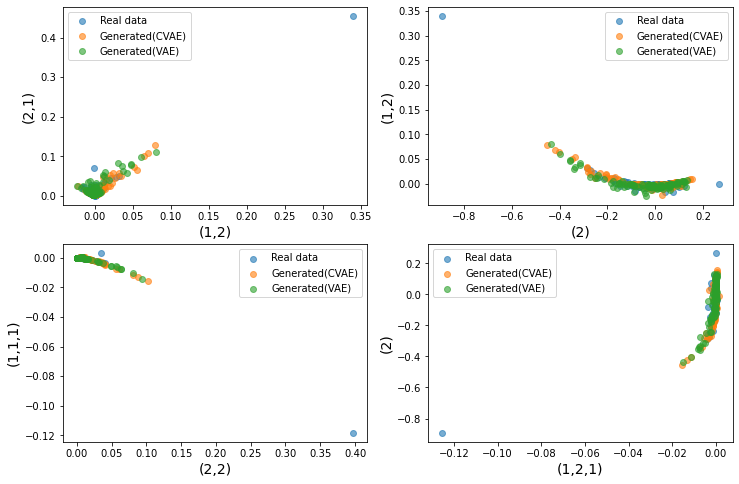

In [12]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

factor = []
for i in keys:
    factor.append((np.ceil((len(i)-2)/2)))
factor = np.array(factor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(test_sig[:, projection[0]], test_sig[:, projection[1]],
                label="Real data", alpha = 0.6)
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated(CVAE)", alpha = 0.6)
    plt.scatter(generated_sigs2[:, projection[0]], generated_sigs2[:, projection[1]],
               label="Generated(VAE)", alpha = 0.6)
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
    
plt.show()

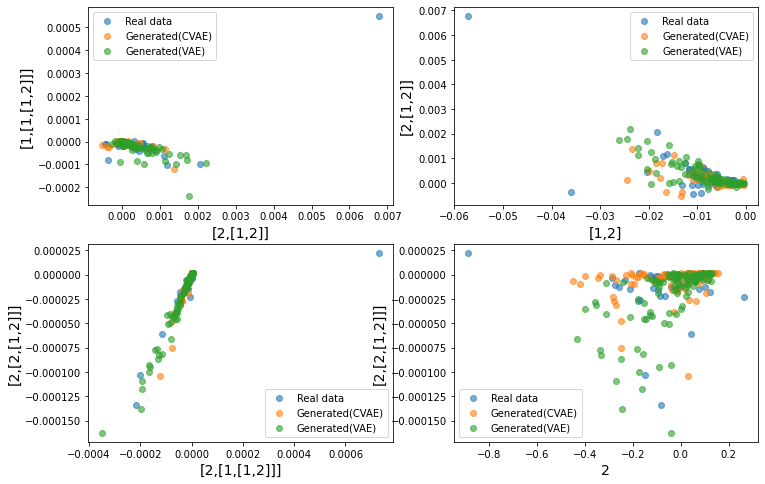

In [13]:
from esig.tosig import logsigkeys
import re

logkeys = logsigkeys(2, order).split()

logfactor = []
for i in logkeys:
    logfactor.append((len(re.sub("\D", "", i))))
logfactor = np.array(logfactor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (1, 7)]

x = plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i+1)

    plt.scatter(test_logsig[:, projection[0]], test_logsig[:, projection[1]],
                label="Real data", alpha=0.6)
    plt.scatter(generated[:, projection[0]], generated[:, projection[1]],
               label="Generated(CVAE)", alpha=0.6)
    plt.scatter(generated2[:, projection[0]], generated2[:, projection[1]],
               label="Generated(VAE)", alpha=0.6)
    plt.xlabel(logkeys[projection[0]], fontsize=14)
    plt.ylabel(logkeys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

## Evaluation

In [14]:
import evaluation
reload(evaluation)

import process_discriminator
reload(process_discriminator)

<module 'process_discriminator' from '../src\\process_discriminator.py'>

In [15]:
windows_test = _load_rough_bergomi(params)
test_sig = np.array([_sig(path) for path in tqdm(windows_test, desc="Computing signatures")])

normalised_generated = np.array([generator.generate(cond)[0] for cond in conditions])
generated = scaler.inverse_transform(normalised_generated)
generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

normalised_generated2 = model.generate(conditions)
generated2 = scaler.inverse_transform(normalised_generated2)
generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

phi1 = process_discriminator.T_global(test_sig, generated_sigs2,\
                                     order=4, verbose=False, normalise=True, compute_sigs=False)
phi2 = process_discriminator.T_global(test_sig[1:], generated_sigs,\
                                     order=4, verbose=False, normalise=True, compute_sigs=False)
phi = min(phi1,phi2)


0.9999999999961086
0.9999999999961086


In [17]:
TU_VAE = []
TU_CVAE = []
for i in range(50):
    windows_test = _load_rough_bergomi(params)
    test_sig = np.array([_sig(path) for path in tqdm(windows_test, desc="Computing signatures")])

    normalised_generated = np.array([generator.generate(cond)[0] for cond in conditions])
    generated = scaler.inverse_transform(normalised_generated)
    generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
    # real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

    normalised_generated2 = model.generate(conditions)
    generated2 = scaler.inverse_transform(normalised_generated2)
    generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
    # real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])
    
    result, TU = process_discriminator.test_fix(test_sig[1:], generated_sigs2,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU_VAE.append(TU)
    result, TU = process_discriminator.test_fix(test_sig[1:], generated_sigs,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU_CVAE.append(TU)


0.9999999999961086
c: 0.04030256447915187
TU: 0.004165594407459228
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.005518235622453016
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0004150016773802889
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.005178248221191506
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.008072465543048413
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0060679677400736765
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.003226165455999297
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.010895217360961995
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0061105427130945245
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.009303208769321225
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.005455703511512366
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.011710895774844632
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.003936771579659437
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.00874198572719398
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.006061775877540754
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0023667409980481224
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0009124292854509886
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.007003130846585437
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0046226803986222365
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.001834154332737814
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0063164683980097
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.010768414403208304
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0008304155459657458
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.004997072581705897
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.015299324877986908
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.00966325622614339
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0025699621386672256
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0029897456966554437
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.010366042570575829
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.010029909816091198
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.009088310306546
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.012052060378149099
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0035196662656704625
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.003984650116072963
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0044853658827541665
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.013573519188784022
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0006829098894423069
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0045212551785553945
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.004346024994243525
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.013462959490041282
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0023932209854788944
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.008212978472312393
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.001100261471440156
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.002370135162955922
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.008491946027625152
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.009638992144699543
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0055339061510464305
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0031771284298613978
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.01176527996704646
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0033397072901943936
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.01073534375368057
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.009882129314738641
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.003276853478054953
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0009649635647144272
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0049857223243023885
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.005807426771347268
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.013079282339809595
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.008274854267287246
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.005238815954090592
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.00684691438766416
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.001373028011858235
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0022347752543541155
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0067719742062353205
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.004017860379571303
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0057052253156546495
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0044858013611981384
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.006250777289091847
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0016708061773464955
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0022656016466804374
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.005481948682373172
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.005213093050247419
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.008334473317844981
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0031971331053628482
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.004108005868461273
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.01149201540708189
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.011346300843841473
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.003547624687607831
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.003981709170103764
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0029658188944581276
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.007451791140120845
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.004395998770562404
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0062551971583528765
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.002142188841060211
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.006806641267836255
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0062256832609934865
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0024250308272606436
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0014218876718277151
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.004331355821435512
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.00140257274311395
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.005568693997918928
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0024203393511168514
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.00342022805889286
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0017953715631249256
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.009534579011750477
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.004028246274833336
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.008305963523874915
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.003276167866244517
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0017744181954810756
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.0008860498765237423
m: 99



0.9999999999961086
c: 0.04030256447915187
TU: 0.001129041909419648
m: 99


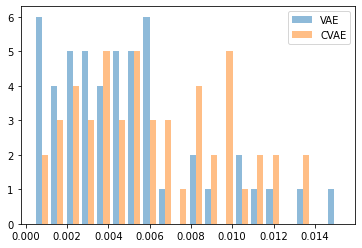

In [18]:
plt.hist(np.array([TU_VAE,TU_CVAE]).T, bins = 20, alpha = 0.5)
plt.legend(['VAE','CVAE'])
plt.show()

## From Signature to Path

In [9]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag
from gpsig import kernels
import gpflow

In [10]:
pip = 0.001
n_pips = 5 * 10
n_points = 28
n_iterations = 100
n_organisms = 100
recovered_paths = []
for i, logsig in enumerate(generated):
    recovered_paths.append(logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points, pip, n_pips)[0] + 1.)
    

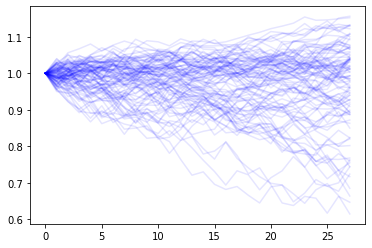

In [15]:
plt.plot(np.array(recovered_paths).T, "b", alpha=0.1)
plt.show()